Random Forest Accuracy: 37.88%
SVM Accuracy: 0.76%


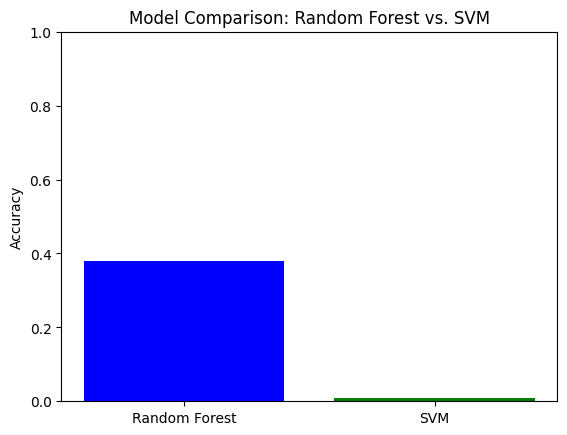

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import jellyfish

# Load data
df = pd.read_csv('final.csv')

# Preprocessing function (you can modify this according to your exact requirements)
def preprocess_word(word, max_length=20):
    word = word.lower().ljust(max_length)[:max_length]  # Normalize length
    char_to_int = {c: i+1 for i, c in enumerate(set(''.join(df['Incorrect_Word'])))}
    return [char_to_int.get(c, 0) for c in word]

def phonetic_features(word):
    # Phonetic features like Levenshtein distance, Soundex, and others
    word = word.lower()
    soundex = jellyfish.soundex(word)
    metaphone = jellyfish.metaphone(word)
    return [len(word), jellyfish.levenshtein_distance(word, word), int(soundex == metaphone)]

# Prepare features and labels
df['Processed_Words'] = df['Incorrect_Word'].apply(preprocess_word)
df['Phonetic_Features'] = df['Incorrect_Word'].apply(phonetic_features)

X = np.array([processed + phonetic for processed, phonetic in zip(df['Processed_Words'], df['Phonetic_Features'])])
y = df['Error_Type'].apply(lambda x: x.split(',') if isinstance(x, str) else [x])

# MultiLabelBinarizer to handle multiple error types
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train SVM Model using One-vs-Rest Strategy for multi-label classification
svm_model = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
svm_model.fit(X_train, y_train)

# Predict using both models
rf_preds = rf_model.predict(X_test)
svm_preds = svm_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)
svm_accuracy = accuracy_score(y_test, svm_preds)

print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

# Comparison Graph
models = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Comparison: Random Forest vs. SVM')
plt.ylim(0, 1)
plt.show()


#One-vs-Rest (OvR) Strategy: This can be used to convert multi-label problems into multiple binary classification tasks (one per class).

Modify y to work with multi-output classification: This will involve converting the multi-label output (y) into a binary format for each possible error type.





Epoch 1/10


14/14 [==============================] - 2s 31ms/step - loss: 0.5945 - accuracy: 0.1792 - val_loss: 0.5113 - val_accuracy: 0.2336
Epoch 2/10
14/14 [==============================] - 0s 10ms/step - loss: 0.5079 - accuracy: 0.2193 - val_loss: 0.4975 - val_accuracy: 0.2243
Epoch 3/10
14/14 [==============================] - 0s 10ms/step - loss: 0.4871 - accuracy: 0.3349 - val_loss: 0.4909 - val_accuracy: 0.3178
Epoch 4/10
14/14 [==============================] - 0s 10ms/step - loss: 0.4661 - accuracy: 0.4127 - val_loss: 0.4885 - val_accuracy: 0.2897
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 0.4458 - accuracy: 0.4552 - val_loss: 0.4864 - val_accuracy: 0.3271
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 0.4211 - accuracy: 0.4811 - val_loss: 0.4939 - val_accuracy: 0.3178
Epoch 7/10
14/14 [==============================] - 0s 8ms/step - loss: 0.3949 - accuracy: 0.5448 - val_loss: 0.4887 - val_accuracy: 0.3178
Epoch 8/10

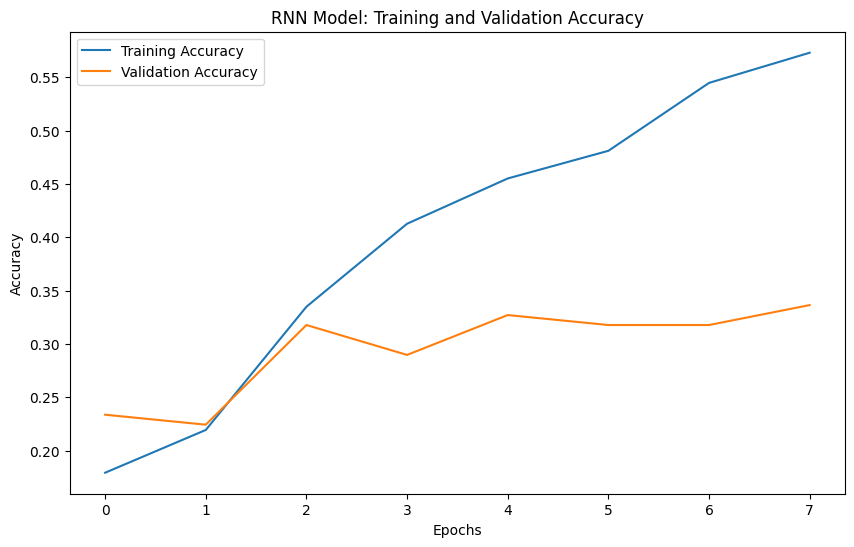

In [4]:
#RNN
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("final.csv")

# Preprocess data (assuming similar preprocessing as BiLSTM model)
# You can adapt this code based on your actual preprocessing steps
class DataProcessor:
    def __init__(self, dataset_path):
        self.df = pd.read_csv(dataset_path)
        self.df = self.clean_dataset(self.df)
        self.correct_words = set(self.df['Correct_Word'].str.lower())
        self.incorrect_words = set(self.df['Incorrect_Word'].str.lower())
        self.all_words = pd.concat([self.df['Incorrect_Word'], self.df['Correct_Word']]).unique()
        self.unique_words = len(set(self.all_words))
        self._create_char_encoding()
        self.df['Error_Type'] = self.df['Error_Type'].apply(lambda x: x.split(',') if ',' in x else [x])
        self.error_types = sorted(set([et for sublist in self.df['Error_Type'] for et in sublist]))
        self.label_encoder = {et: i for i, et in enumerate(self.error_types)}
        self.inverse_label_encoder = {i: et for et, i in self.label_encoder.items()}
        self.max_difficulty = self.df['Difficulty_Level'].max()

    def _create_char_encoding(self):
        chars = set(''.join(self.all_words))
        self.char_to_int = {c: i+1 for i, c in enumerate(chars)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}
        self.max_length = int(np.percentile([len(word) for word in self.all_words], 95))

    def preprocess_word(self, word):
        processed = word.lower().ljust(self.max_length)[:self.max_length]
        return [self.char_to_int.get(c, 0) for c in processed]

    def clean_dataset(self, df):
        df.loc[df['Incorrect_Word'] == df['Correct_Word'], 'Error_Type'] = ['Correct']
        return df.drop_duplicates(subset=['Incorrect_Word', 'Correct_Word'], keep='first')

processor = DataProcessor("final.csv")
df = processor.df

# Prepare data for training
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
X_train_seq = np.array([processor.preprocess_word(w) for w in train_df['Incorrect_Word']])
X_val_seq = np.array([processor.preprocess_word(w) for w in val_df['Incorrect_Word']])

y_train_error = np.array([[1 if et in errors else 0 for et in processor.error_types] for errors in train_df['Error_Type']])
y_val_error = np.array([[1 if et in errors else 0 for et in processor.error_types] for errors in val_df['Error_Type']])

# Define RNN Model
model = Sequential()
model.add(Embedding(input_dim=len(processor.char_to_int)+1, output_dim=128, input_length=processor.max_length, mask_zero=True))
model.add(SimpleRNN(256, return_sequences=True, dropout=0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(processor.error_types), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq, y_train_error, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val_error),
                    callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                               ModelCheckpoint('best_rnn_model.keras', save_best_only=True, monitor='val_loss')],
                    verbose=1)

# Evaluate the model
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('RNN Model: Training and Validation Accuracy')
plt.legend()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (424,) + inhomogeneous part.